# Predicting galaxy redshift from band magnitudes with XGBoost

Zooey Nguyen

2021-07-01

mostly same code as `HSC Photo-Z Data and Simple Model Exploration.ipynb`

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Import photoz data + filter out bad objects

These are some of the criteria from Schuldt et al. 2020
* source type is GALAXY or LRG 
* z>0
* z != 9.99992
* 0<zerr <1
* the galaxy identification number (ID) is unique
* specz flag homogeneous is False

In [38]:
photozdata = pd.read_csv('/data/HSC/HSC_IMAGES_FIXED/HSC_photozdata_full_header_trimmed.csv')
filt = (photozdata['specz_redshift'] < 4) & (photozdata['specz_redshift'] > 0)& (photozdata['specz_redshift_err'] > 0) \
       & (photozdata['specz_redshift_err'] < 1)
photozdata_subset = photozdata[filt]

In [3]:
photozdata


,object_id_1,ra,dec,coord,skymap_id,g_cmodel_mag,r_cmodel_mag,i_cmodel_mag,z_cmodel_mag,y_cmodel_mag,...,i_cmodel_magsigma,z_cmodel_magsigma,y_cmodel_magsigma,object_id_2,specz_redshift_err,specz_redshift,specz_mag_i,specz_name,specz_ra,specz_dec
0,3.640710e+16,29.056840,-6.577962,"'(179117.015625, 99518.6015625, -23628.67578125)'",82780005,22.837498,21.159600,19.852673,19.388730,19.089922,...,0.004001,0.006953,0.007002,3.640710e+16,0.000300,0.693590,19.652000,SDSS-DR12-1237679340566217300,29.056771,-6.577981
1,3.641160e+16,30.350384,-6.107037,"'(176986.390625, 103631.3828125, -21943.728515...",82790107,22.242287,21.505087,20.884990,20.588097,20.394600,...,0.002920,0.004457,0.007763,3.641160e+16,0.000330,0.687360,20.907000,SDSS-DR12-1237679341103677901,30.350340,-6.107040
2,3.641140e+16,30.558539,-6.526887,"'(176465.515625, 104189.1328125, -23446.0078125)'",82790005,22.436127,21.514544,21.500206,20.762743,20.606396,...,0.004906,0.004987,0.009204,3.641140e+16,0.000730,3.352120,20.885000,SDSS-DR12-1237679340566872600,30.558516,-6.526930
3,3.641160e+16,30.383171,-6.169957,"'(176906.15625, 103720.390625, -22168.94140625)'",82790107,22.804676,22.235598,21.882067,21.826208,21.726620,...,0.006623,0.010950,0.024310,3.641160e+16,0.031370,0.920660,21.729000,SDSS-DR12-1237679439886287299,30.383171,-6.169992
4,3.641170e+16,30.200514,-6.105444,"'(177257.375, 103168.3828125, -21938.025390625)'",82790207,22.178066,21.270580,20.574970,20.477303,19.997612,...,0.001957,0.003098,0.004146,3.641170e+16,0.001460,4.034980,20.028000,SDSS-DR12-1237679341103612342,30.200520,-6.105411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52586,7.464890e+16,214.336409,52.680203,"'(-103259.4296875, -70535, 164034.984375)'",169730603,25.211388,24.020172,23.853104,23.896875,23.536343,...,0.032832,0.082620,0.168244,7.464890e+16,0.000109,1.471458,23.687145,DEEP3-201701-12021069,214.336332,52.680213
52587,7.464900e+16,214.152903,52.378941,"'(-104197.125, -70687.15625, 163375.203125)'",169730702,26.590466,24.810654,24.754406,24.790068,26.337290,...,0.051401,0.139490,1.493244,7.464900e+16,0.000228,0.963095,23.660664,DEEP3-201701-11051794,214.152818,52.379124
52588,7.464900e+16,214.197139,52.409241,"'(-104071.0390625, -70719.0078125, 163441.7656...",169730702,25.057400,24.120800,24.029400,24.019863,23.684252,...,0.024213,0.076674,0.125941,7.464900e+16,0.000144,0.913161,23.950352,DEEP3-201701-12004809,214.197161,52.409340
52589,7.464900e+16,214.176570,52.533124,"'(-103803.8125, -70482.9609375, 163713.4375)'",169730703,25.288311,24.519330,23.918001,23.035270,22.241425,...,0.034606,0.041634,0.071799,7.464900e+16,0.000102,1.227861,24.015530,DEEP3-201701-12012997,214.176593,52.533211


In [4]:
photozdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52591 entries, 0 to 52590
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   object_id_1         52591 non-null  float64
 1   ra                  52591 non-null  float64
 2   dec                 52591 non-null  float64
 3   coord               52591 non-null  object 
 4   skymap_id           52591 non-null  int64  
 5   g_cmodel_mag        52591 non-null  float64
 6   r_cmodel_mag        52591 non-null  float64
 7   i_cmodel_mag        52591 non-null  float64
 8   z_cmodel_mag        52591 non-null  float64
 9   y_cmodel_mag        52591 non-null  float64
 10  g_cmodel_magsigma   52591 non-null  float64
 11  r_cmodel_magsigma   52591 non-null  float64
 12  i_cmodel_magsigma   52591 non-null  float64
 13  z_cmodel_magsigma   52591 non-null  float64
 14  y_cmodel_magsigma   52591 non-null  float64
 15  object_id_2         52591 non-null  float64
 16  spec

In [5]:
check_nan =photozdata.isnull().values.any()
check_nan

True

In [6]:
photozdata.isna().sum().sum()

1810

In [52]:
photozdata['g_cmodel_mag'].isnull().sum()

0

In [7]:
photozdata.describe()

,object_id_1,ra,dec,skymap_id,g_cmodel_mag,r_cmodel_mag,i_cmodel_mag,z_cmodel_mag,y_cmodel_mag,g_cmodel_magsigma,r_cmodel_magsigma,i_cmodel_magsigma,z_cmodel_magsigma,y_cmodel_magsigma,object_id_2,specz_redshift_err,specz_redshift,specz_mag_i,specz_ra,specz_dec
count,5.259100e+04,52591.000000,52591.000000,5.259100e+04,52591.000000,52591.000000,52591.000000,52591.000000,52591.000000,52591.000000,52591.000000,52591.000000,52591.000000,52591.000000,5.259100e+04,5.259100e+04,52591.000000,50781.000000,52591.000000,52591.000000
mean,4.201555e+16,185.410996,0.765024,9.553138e+07,23.326798,22.448803,21.766862,21.393757,21.201781,0.089189,0.021180,0.010745,0.020102,0.046959,4.201555e+16,5.156705e-03,0.840776,21.413399,185.410994,0.765055
std,6.715175e+15,135.107930,10.328968,1.526853e+07,1.285471,1.269242,1.287839,1.300397,1.318983,12.654079,0.025612,0.016128,0.034232,1.738207,6.715175e+15,4.873631e-02,0.714068,5.141998,135.107935,10.328963
min,3.640710e+16,0.004770,-7.244807,8.278000e+07,16.535921,15.585190,15.075962,14.731529,14.492533,0.000279,0.000244,0.000165,0.000193,0.000248,3.640710e+16,3.760000e-08,0.000004,-99.000000,0.004738,-7.244795
25%,3.854530e+16,36.493451,-4.399621,8.764060e+07,22.682315,21.867273,21.169539,20.777589,20.566622,0.011064,0.008119,0.004418,0.007180,0.011384,3.854530e+16,6.000000e-04,0.543125,21.048000,36.493475,-4.399574
50%,4.163190e+16,206.943633,-0.098051,9.466001e+07,23.380280,22.607754,21.925068,21.519438,21.324700,0.018551,0.014650,0.007265,0.012267,0.020336,4.163190e+16,8.100000e-04,0.731400,21.837000,206.943640,-0.098114
75%,4.264000e+16,333.401045,1.285681,9.695071e+07,24.096104,23.184216,22.421049,22.069298,21.901840,0.032653,0.024451,0.011291,0.020002,0.034230,4.264000e+16,9.400000e-04,0.946100,22.312000,333.401087,1.285690
max,7.464920e+16,359.999038,53.256213,1.697308e+08,34.930744,27.396523,27.189955,27.018696,31.789879,2888.685800,0.945125,0.636073,3.054967,382.232670,7.464920e+16,9.991000e-01,9.999000,61.178000,359.998990,53.256214


## Make train and test sets on filtered data

In [8]:
X = photozdata_subset[['g_cmodel_mag','r_cmodel_mag','i_cmodel_mag','z_cmodel_mag','y_cmodel_mag']]
y = photozdata_subset['specz_redshift']


In [9]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X)

[0.14239621 0.33740658 0.23385364 0.14921151 0.13713206]


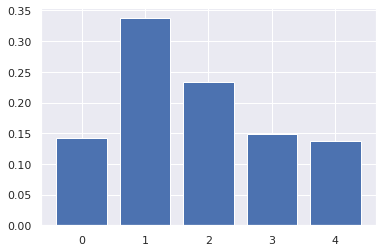

In [10]:
# plot feature importance manually
from numpy import loadtxt
from matplotlib import pyplot
# load data
# fit model no training data
model = XGBRegressor()
model.fit(X, y)
# feature importance
print(model.feature_importances_)
# plot
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

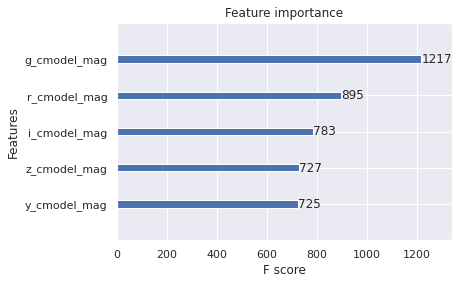

In [11]:

from xgboost import plot_importance
plot_importance(model)
pyplot.show()

In [12]:
X.corr()

,g_cmodel_mag,r_cmodel_mag,i_cmodel_mag,z_cmodel_mag,y_cmodel_mag
g_cmodel_mag,1.000000,0.922259,0.815603,0.749171,0.721003
r_cmodel_mag,0.922259,1.000000,0.958108,0.917333,0.896947
i_cmodel_mag,0.815603,0.958108,1.000000,0.984369,0.971563
z_cmodel_mag,0.749171,0.917333,0.984369,1.000000,0.987180
y_cmodel_mag,0.721003,0.896947,0.971563,0.987180,1.000000


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
from tpot import TPOTRegressor
pipeline_optimizer = TPOTRegressor(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)

In [15]:
#pipeline_optimizer.fit(X_train, y_train)



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(ElasticNetCV(input_matrix, l1_ratio=0.75, tol=0.01), bootstrap=True, max_features=0.4, min_samples_leaf=16, min_samples_split=14, n_estimators=100)


TPOTRegressor(generations=5, population_size=20, random_state=42, verbosity=2)

In [16]:
print(pipeline_optimizer.score(X_test, y_test))

-0.1477319044411127


In [17]:
pipeline_optimizer.export('tpot_exported_pipeline.py')


## Train simple XGBoost regression

In [39]:
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=32, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Evaluate training fit

MSE: 0.08739814294416545


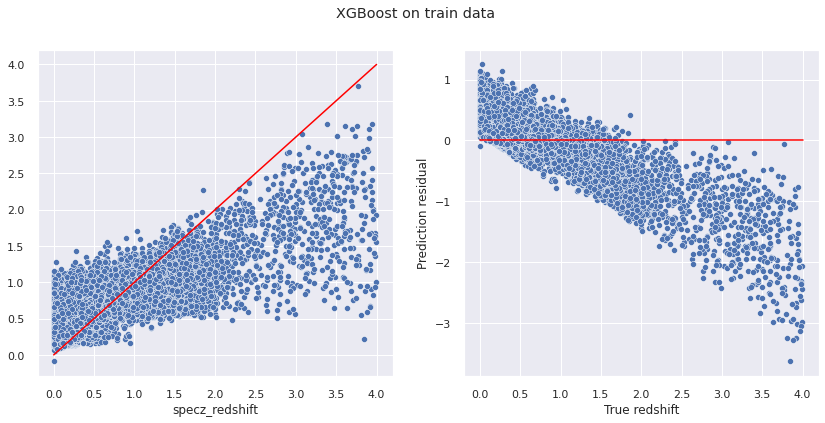

In [40]:
y_train_predict = xgb_model.predict(X_train)

xgb_mse = mean_squared_error(y_train, y_train_predict)
print(f"MSE: {xgb_mse}")

fig, axes = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle("XGBoost on train data")
sns.scatterplot(x=y_train, y=y_train_predict, ax=axes[0])
axes[0].plot([0,4], [0,4], color='red')
sns.scatterplot(x=y_train, y=y_train_predict-y_train, ax=axes[1])
axes[1].set(xlabel='True redshift', ylabel='Prediction residual')
axes[1].plot([0,4], [0,0], color='red')

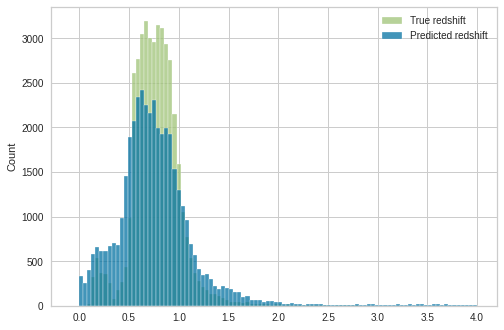

In [27]:
fig = sns.histplot([y_train, y_train_predict], bins=100)
fig.legend(labels=['True redshift', 'Predicted redshift'])

## Evaluate test fit

MSE: 0.16027498585357103


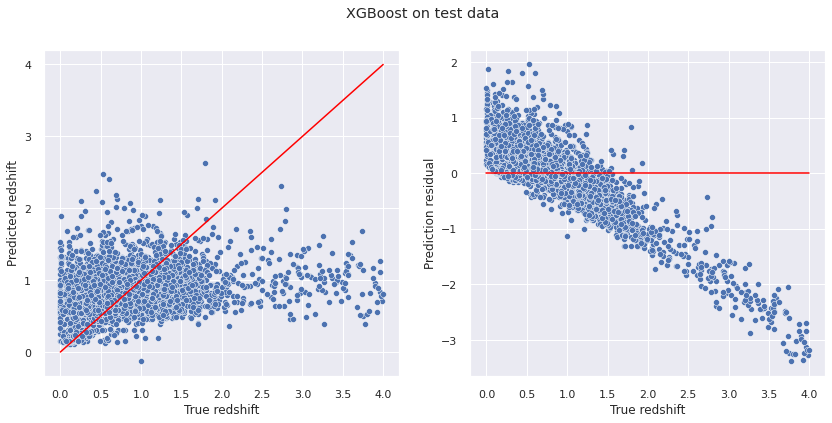

In [41]:
y_test_predict = xgb_model.predict(X_test)

xgb_mse = mean_squared_error(y_test, y_test_predict)
print(f"MSE: {xgb_mse}")

fig, axes = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle("XGBoost on test data")
sns.scatterplot(x=y_test, y=y_test_predict, ax=axes[0])
axes[0].set(xlabel='True redshift', ylabel='Predicted redshift')
axes[0].plot([0,4], [0,4], color='red')
sns.scatterplot(x=y_test, y=y_test_predict-y_test, ax=axes[1])
axes[1].set(xlabel='True redshift', ylabel='Prediction residual')
axes[1].plot([0,4], [0,0], color='red')

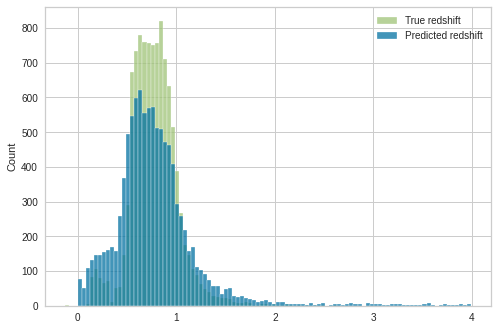

In [29]:
fig = sns.histplot([y_test, y_test_predict], bins=100)
fig.legend(labels=['True redshift', 'Predicted redshift'])

In [30]:
from yellowbrick.regressor import prediction_error
from yellowbrick.regressor import residuals_plot



Prediction Error Plot


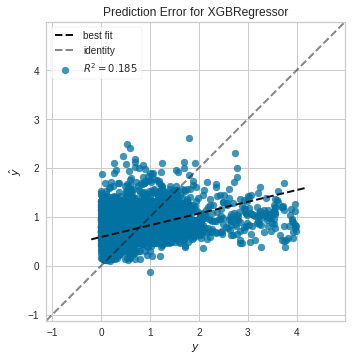

PredictionError(ax=<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>,
                estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                       colsample_bylevel=1, colsample_bynode=1,
                                       colsample_bytree=1, gamma=0, gpu_id=-1,
                                       importance_type='gain',
                                       interaction_constraints='',
                                       learning_rate=0.300000012,
                                       max_delta_step=0, max_depth=6,
                                       min_child_weight=1, missing=nan,
                                       monotone_constraints='()',
                                       n_estimators=100, n_jobs=32,
                                       num_parallel_tree=1, random_state=0,
                                       reg_alpha=0, reg_lambda=1,
                                

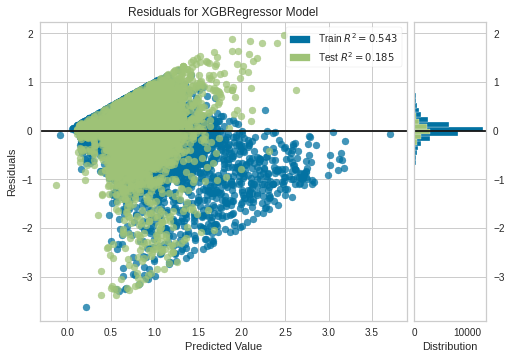

AttributeError: 'XGBRegressor' object has no attribute 'line_color'

In [31]:
# Making the Prediction Error Plot
print("\nPrediction Error Plot")
print(prediction_error(xgb_model, X_train, y_train, X_test, y_test))

# Making the Residuals Plot
print("\nResiduals Plot")
print(residuals_plot(xgb_model, X_train, y_train, X_test, y_test))

In [32]:
photozdata.head()

,object_id_1,ra,dec,coord,skymap_id,g_cmodel_mag,r_cmodel_mag,i_cmodel_mag,z_cmodel_mag,y_cmodel_mag,...,i_cmodel_magsigma,z_cmodel_magsigma,y_cmodel_magsigma,object_id_2,specz_redshift_err,specz_redshift,specz_mag_i,specz_name,specz_ra,specz_dec
0,3.640710e+16,29.056840,-6.577962,"'(179117.015625, 99518.6015625, -23628.67578125)'",82780005,22.837498,21.159600,19.852673,19.388730,19.089922,...,0.004001,0.006953,0.007002,3.640710e+16,0.00030,0.69359,19.652,SDSS-DR12-1237679340566217300,29.056771,-6.577981
1,3.641160e+16,30.350384,-6.107037,"'(176986.390625, 103631.3828125, -21943.728515...",82790107,22.242287,21.505087,20.884990,20.588097,20.394600,...,0.002920,0.004457,0.007763,3.641160e+16,0.00033,0.68736,20.907,SDSS-DR12-1237679341103677901,30.350340,-6.107040
2,3.641140e+16,30.558539,-6.526887,"'(176465.515625, 104189.1328125, -23446.0078125)'",82790005,22.436127,21.514544,21.500206,20.762743,20.606396,...,0.004906,0.004987,0.009204,3.641140e+16,0.00073,3.35212,20.885,SDSS-DR12-1237679340566872600,30.558516,-6.526930
3,3.641160e+16,30.383171,-6.169957,"'(176906.15625, 103720.390625, -22168.94140625)'",82790107,22.804676,22.235598,21.882067,21.826208,21.726620,...,0.006623,0.010950,0.024310,3.641160e+16,0.03137,0.92066,21.729,SDSS-DR12-1237679439886287299,30.383171,-6.169992
4,3.641170e+16,30.200514,-6.105444,"'(177257.375, 103168.3828125, -21938.025390625)'",82790207,22.178066,21.270580,20.574970,20.477303,19.997612,...,0.001957,0.003098,0.004146,3.641170e+16,0.00146,4.03498,20.028,SDSS-DR12-1237679341103612342,30.200520,-6.105411


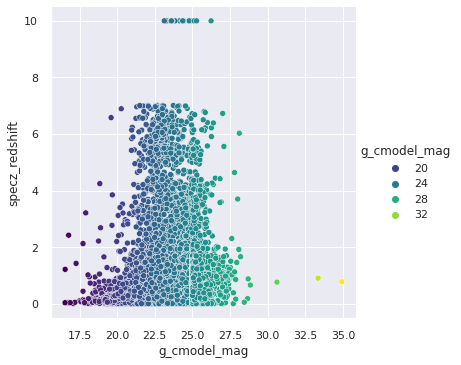

<Figure size 1800x720 with 0 Axes>

In [46]:
sns.relplot(x="g_cmodel_mag", y="specz_redshift",palette='viridis', hue='g_cmodel_mag',  data=photozdata)
plt.figure(figsize=(25,10))

plt.show()

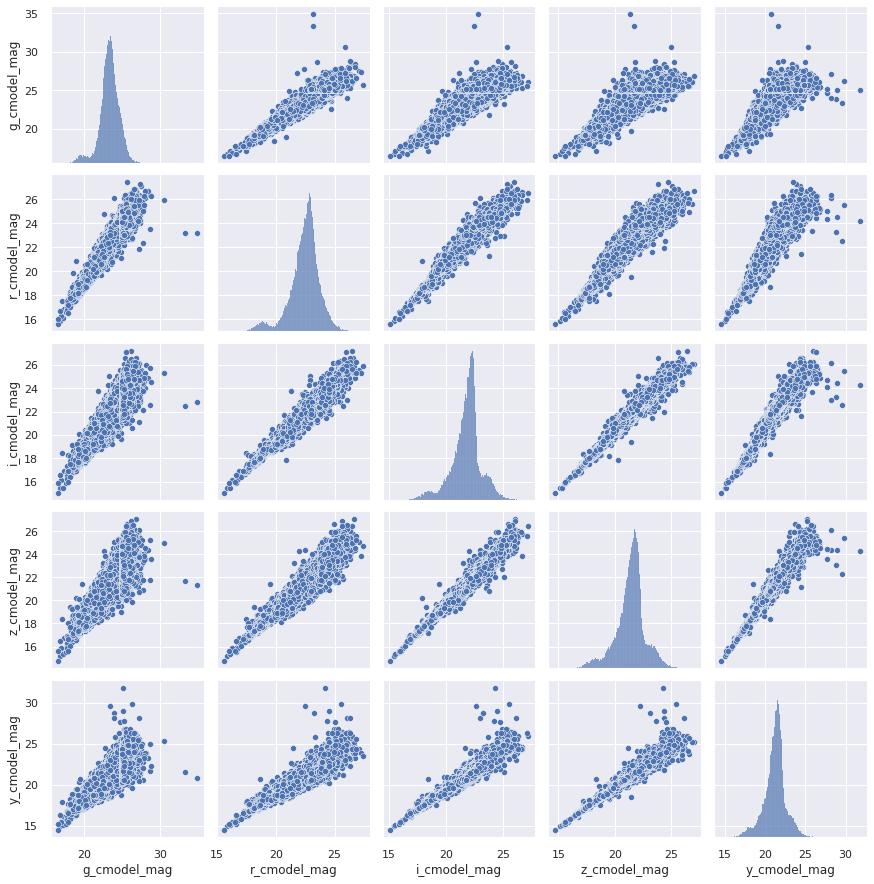

In [44]:
sns.pairplot(X)

In [ ]:
sns.relplot(x="clicks", y="sales",  ci="sd", hue='sale_amount_usd',palette="viridis",data=df)